In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from scipy.optimize import curve_fit
import re
from matplotlib.backends.backend_pdf import PdfPages
import math

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [4]:
# paths
base_dir = '/Users/jenndisanto/Documents/2022/changlab-rotation/data/logfiles'

# get list of files
files = glob.glob('%s/EC*.csv' % (base_dir))

# put all data into one dataframe
dfs = list()
subjects = list()
for f in files:
    subject = re.search("EC\d\d\d", f).group()

    df = pd.read_csv(f)
    df = df[np.array([str(s) != 'nan' for s in df['stim_number']])]

    if df['block_type'].unique() == 2:  # mirror the data scale for block types 2

        d = df['slider.response'].values
        d = np.abs(d - 11)
        df['slider.response'] = d
    
    if subject not in subjects: subjects.append(subject)
    dfs.append(df)

df = pd.concat(dfs)
df = df.reset_index()

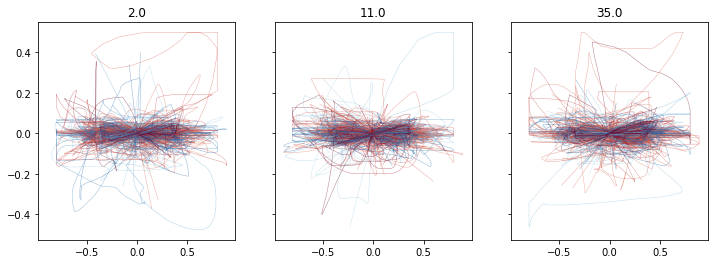

In [39]:
# get mouse x and y
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
for si, stim in enumerate(np.unique(df['stim_number'].values)):
    this_df = df.query("stim_number == @stim and block_type == 1.0" % (stim))
    
    # loop through time
    for tt in range(len(this_df)):

        # params
        c = plt.cm.RdBu_r(df['slider.response'].values[tt] / 10.)
        x = np.array(eval(np.array(this_df['mouse.x'])[tt]))
        y = np.array(eval(np.array(this_df['mouse.y'])[tt]))
#         print(x)
#         break
#     break
    
        # plot this timepoint
        axs[si].plot(x, y, color=c, alpha=0.5, lw=0.5)
    axs[si].set_title(stim)
plt.show()


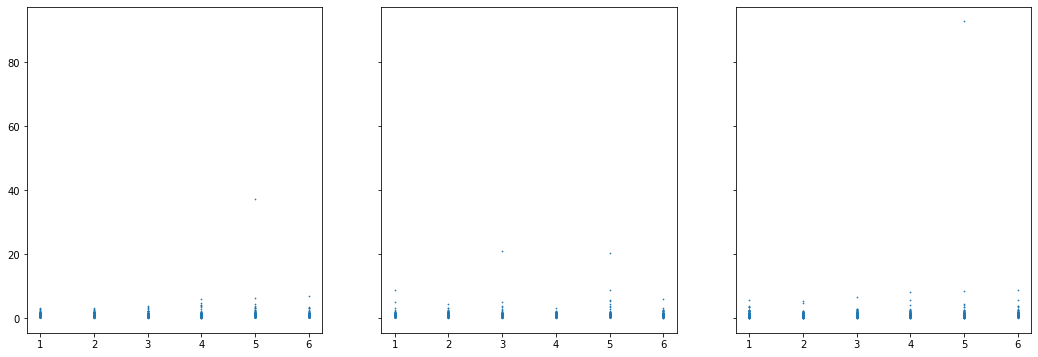

In [135]:
# get mouse x and y
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
for si, stim in enumerate(np.unique(df['stim_number'].values)):
    this_df = df.query("stim_number == @stim")
    
    
    path_lens = list()
    # loop through trials
    for tt in range(len(this_df)):

        # params
        c = plt.cm.RdBu_r(df['slider.response'].values[tt] / 10.)
        x = np.array(eval(np.array(this_df['mouse.x'])[tt]))
        y = np.array(eval(np.array(this_df['mouse.y'])[tt]))
        morph_n = np.array(this_df['resampled'])[tt]
        
        path_len = 0
        for i in range(1,len(x)):
            path_len += math.sqrt(math.pow(x[i]-x[i-1],2) + math.pow(y[i]-y[i-1],2))
        
        path_lens.append(path_len)
    
        # plot this timepoint
    axs[si].plot(this_df['resampled'], path_lens, 'o', ms=0.7)
#     axs[si].violinplot(path_lens, range(1, 7),
#                                showmeans=True, widths=1., showextrema=False,
#                                points=50)
#     axs[si].set_ylim(0,10)
plt.show()


In [136]:
# plot behaviour
def plot_behaviour(df, subject):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
    axs = axs.flatten()
    word_order = [35, 2, 11] #bp, bm, dn
    # subset for word pair
    for si, stim_val in enumerate(word_order):  
        df_sub = df.query("stim_number == @stim_val")


        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]  #phoneme pair - pb, dn, bm
        w1, w2 = np.unique(df_sub['word_end'])


        # loop through words
        for w in [w1, w2]:

            datas = list()
    #         print(datas)
            d_max = []
            paths = list()
            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")
                
                path_lens = list()
                for tt in range(len(df_sub_morph)):

                    # params
                    x = np.array(eval(np.array(df_sub_morph['mouse.x'])[tt]))
                    y = np.array(eval(np.array(df_sub_morph['mouse.y'])[tt]))
                    morph_n = np.array(df_sub_morph['resampled'])[tt]

                    path_len = 0
                    for i in range(1,len(x)):
                        path_len += math.sqrt(math.pow(x[i]-x[i-1],2) + math.pow(y[i]-y[i-1],2))

                    path_lens.append(path_len)

                d = df_sub_morph['slider.rt'].values - df_sub_morph['mouse.started'].values
                
#                 dist = np.abs(df_sub_morph['slider.response'].values - 5.5)
#                 t = df_sub_morph['slider.rt'].values - df_sub_morph['mouse.started'].values

                d = np.array(d, dtype='float')

                d_max.append(max(d))
                axs[si].plot([int(morph_n)]*len(d), path_lens, 'o', color='k', ms=0.1)   #shows slider response per morph
                
                paths.append(path_lens)
                if len(d) > 0:
                    datas.append(d)
                else:
                    datas.append([0]*20)

            axs[si].violinplot(paths, range(1, 7),
                               showmeans=True, widths=1., showextrema=False)

    #         axs[si].set_title('%s' % (w), fontsize=8)

            axs[si].set_ylim([0, 10])


            # labels
            axs[si].set_title('%s-%s' % (w1, w2), fontsize=8)
#         df_sub.to_csv('test1.csv')
# 
    axs[2].set_xlabel('Morph Step')
    axs[2].set_ylabel('Slider Response')
    plt.show()
    return fig

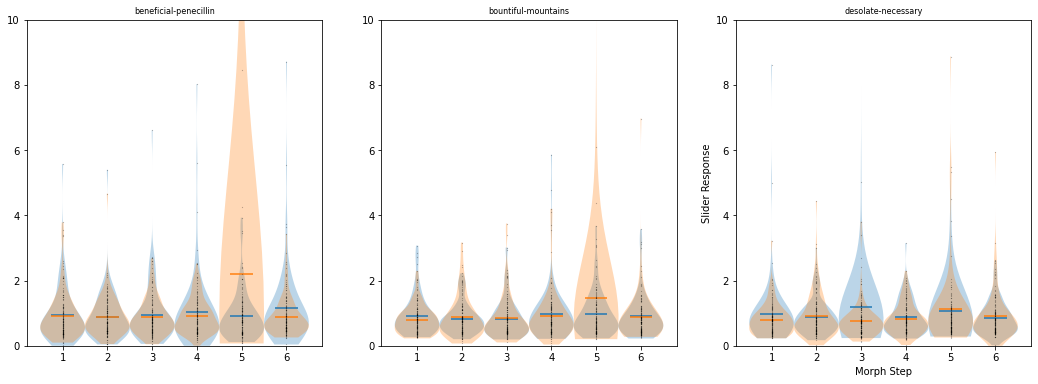

In [137]:
fig = plot_behaviour(df, 0)

In [127]:
# plot slider vs. rt
def plot_slider_rt(df, s):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
    for si, stim in enumerate(np.unique(df['stim_number'].values)):
        df_sub = df.query("stim_number == @stim")

        d = df_sub['slider.response'].values
        rt = df_sub['slider.rt'].values

        axs[si].plot(d, rt, 'o', color='k', ms=0.7)
    #     axs[si].violinplot(path_lens, range(1, 7),
    #                                showmeans=True, widths=1., showextrema=False,
    #                                points=50)
#         axs[si].set_ylim(0,20)
        axs[2].set_xlabel('Slider Response')
        axs[2].set_ylabel('Reaction Time')
    plt.show()
    return fig

EC248


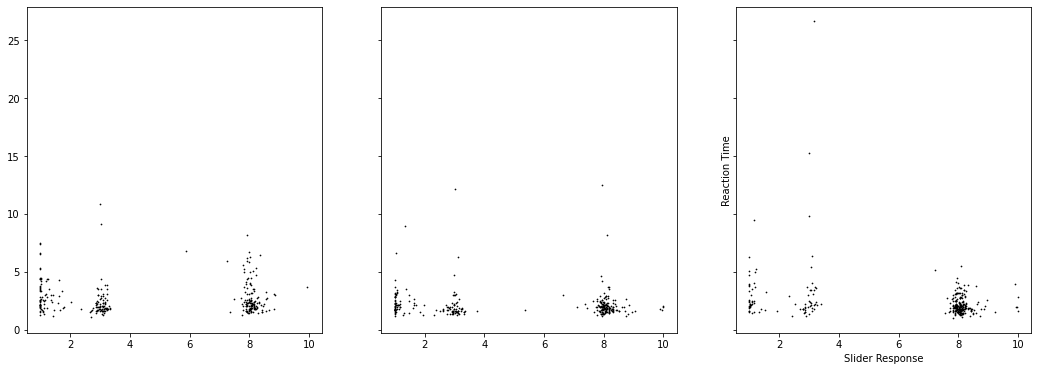

EC253


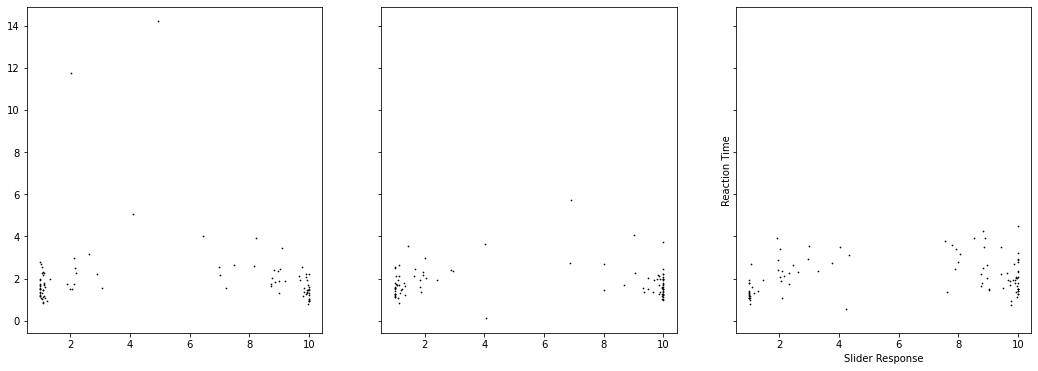

EC243


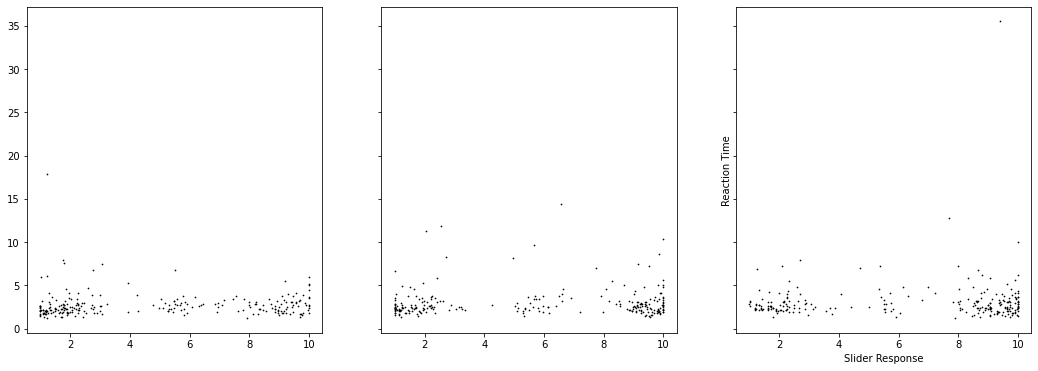

EC250


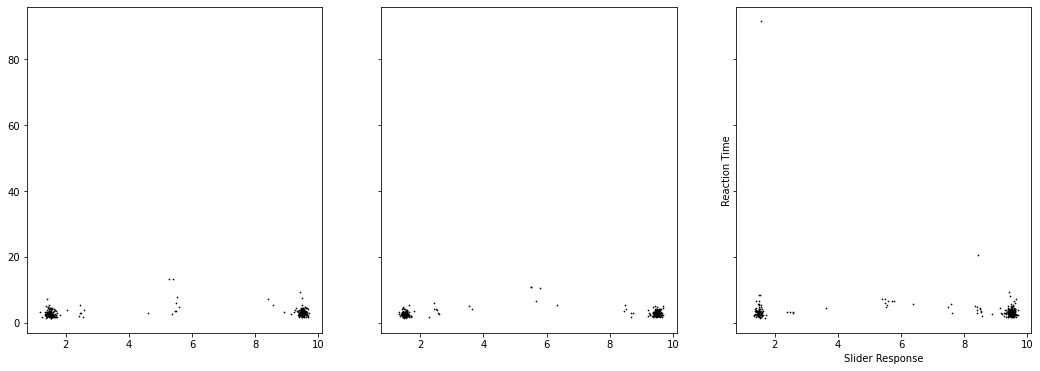

EC237


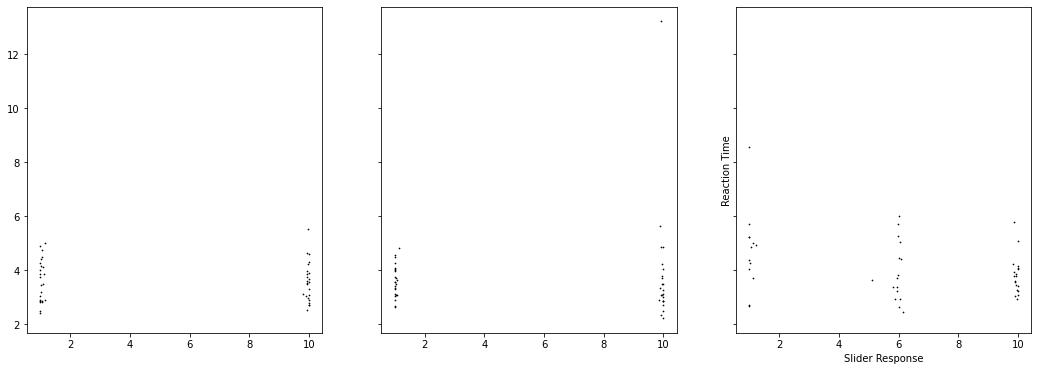

In [128]:
#individual subjects

# plts = PdfPages('individuals_sigmoid_trueline.pdf')
for s in subjects:
    df_s = list()
    for i, file in enumerate(files):
        if s in file: df_s.append(dfs[i])
            
    df_s = pd.concat(df_s)
    df_s = df_s.reset_index()
    print(s)
    plot = plot_slider_rt(df_s, s)

#     plts.savefig(plot)
    
# plts.close()     

In [86]:
# plot behaviour

def true_line(x):
    y = (0.9/5)*x-0.08
    return y

def plot_bias_rt(df, subject):
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)
    axs = axs.flatten()
    word_order = [35, 2, 11] #bp, bm, dn
    for si, stim_val in enumerate(word_order):    #df['stim_number'].unique()
        # subset
        df_sub = df.query("stim_number == @stim_val")   # get only the data for the word-pair

        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]
        w1, w2 = np.unique(df_sub['word_end'])

        # loop through words in pair
        for w in [w1, w2]:   #i.e. for beneficial, penicilin

            # find the continuum step
            if w in ['beneficial','bountiful','necessary']:   #will end up left
                col = 'purple'
                w_left = w
                flip = False

            elif w in ['penecillin','mountains','desolate']:   #will end up right
                col = 'orange'
                w_right = w
                flip = True

            else:
                print("Cannot find pair...")
    
            datas = list()
            d_s = list()
            rts = list()
            morphs = list()
            biases = list()
            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")

                d = df_sub_morph['slider.response'].values
                d = np.array(d, dtype='float')
                
                rt = df_sub_morph['slider.rt'].values
                
                # flip data so that the x-axis means identical acoustic input
                if flip:
                    d = np.abs(d - 11)

                if len(d) > 0:
                    datas.append(d / 10.)
                    d = d / 10.
                    d_s += d.tolist()
                    rts += rt.tolist()
                    morphs += [int(morph_n)]*len(d)
                    
                    #compute distance from true line
                    bias = d - true_line(int(morph_n))
                    biases += bias.tolist()
                else:
                    datas.append([0]*20)

            # compute and plot curve
            axs[si].plot(biases, rts,'o', color=col, label=w, alpha = 0.5)  

        # labels
        axs[si].set_title('%s: %s-%s' % (subject, w_left, w_right), fontsize=8)

    axs[2].set_xlabel('Bias')
    axs[2].set_ylabel('Reaction Time')
    plt.show()
    return fig

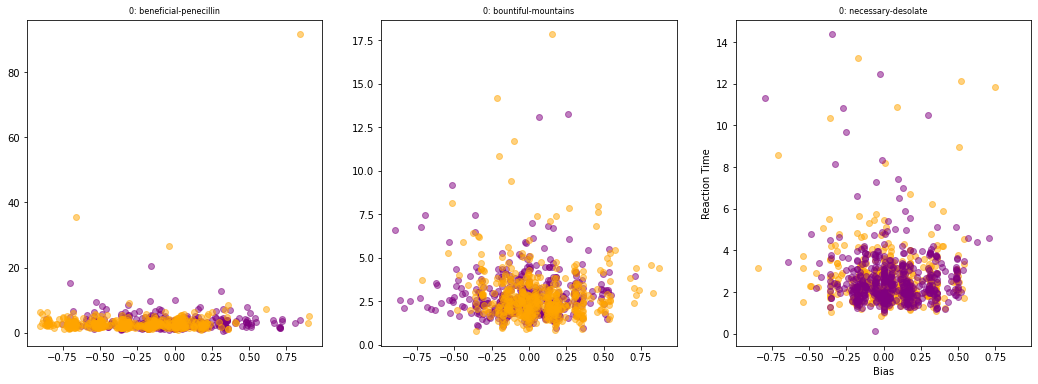

In [88]:
fig = plot_bias_rt(df, 0)

EC248


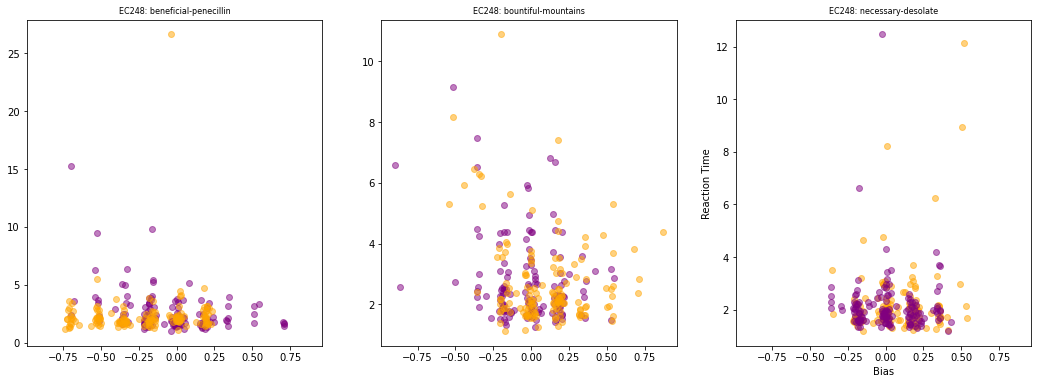

EC253


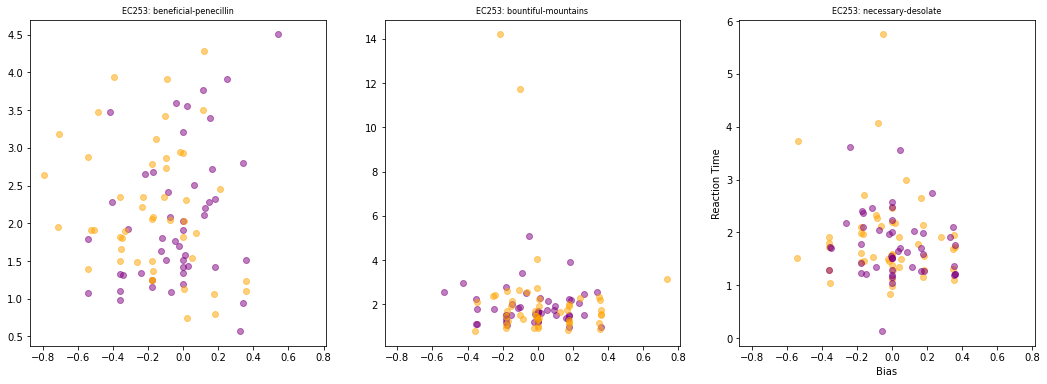

EC243


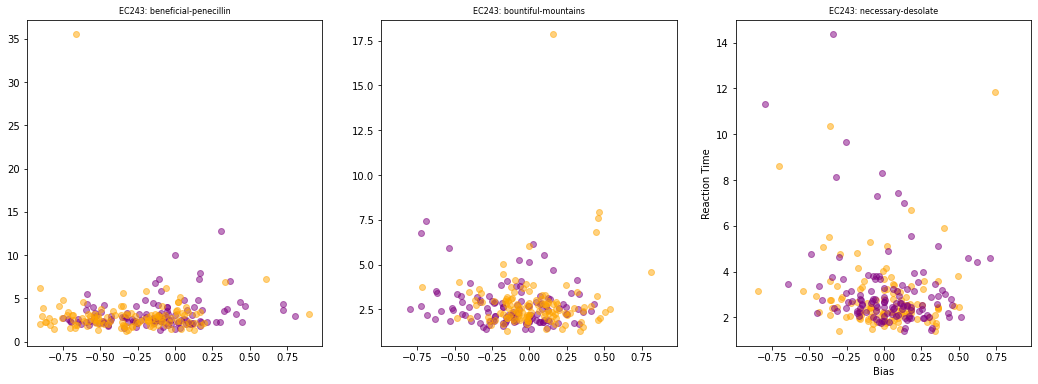

EC250


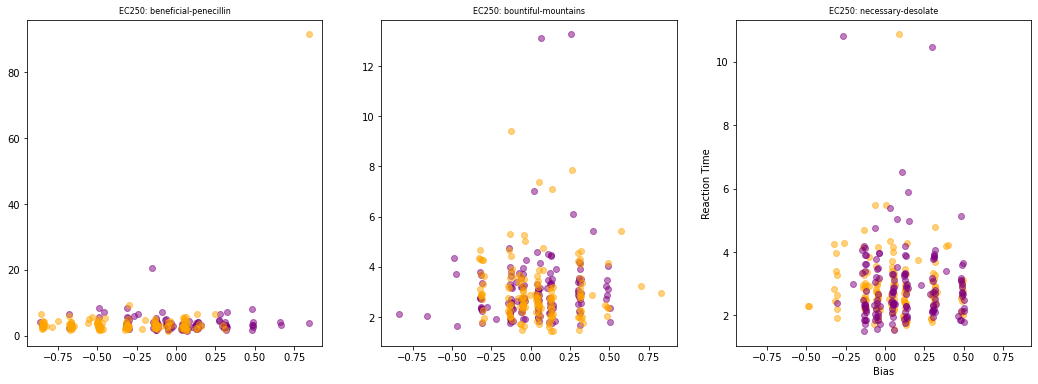

EC237


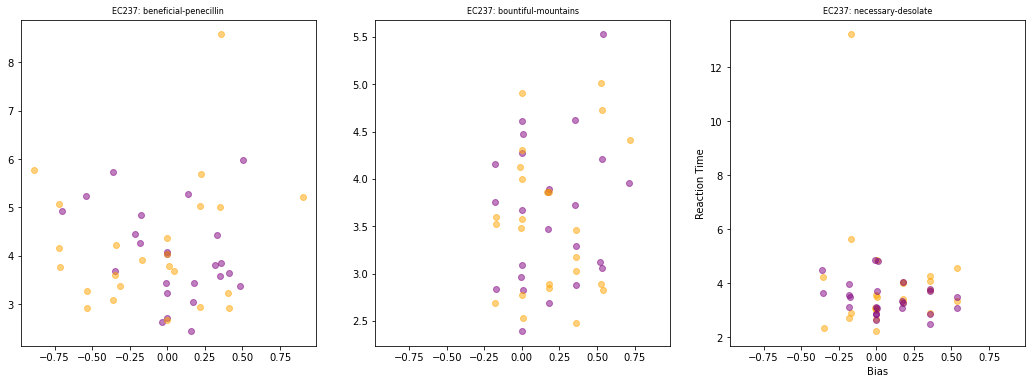

In [87]:
#individual subjects

# plts = PdfPages('individuals_sigmoid_trueline.pdf')

for s in subjects:
    df_s = list()
    for i, file in enumerate(files):
        if s in file: df_s.append(dfs[i])
            
    df_s = pd.concat(df_s)
    df_s = df_s.reset_index()
    print(s)
    plot = plot_bias_rt(df_s, s)

#     plts.savefig(plot)
    
# plts.close()     

In [189]:
# get trials with mouse position outside both limits
def get_mouse_range(df, subject, limits):

    word_order = [35, 2, 11] #bp, bm, dn
    # subset for word pair
    x_min = list()
    x_max = list()
    words = list()
    morphs = list()
    slider = list()
    for si, stim_val in enumerate(word_order):  
        df_sub = df.query("stim_number == @stim_val")


        # get stim phoneme pair and word
        pp = df_sub['phoneme_pair'].values[0]  #phoneme pair - pb, dn, bm
        w1, w2 = np.unique(df_sub['word_end'])

        # loop through words
        for w in [w1, w2]:
            
            if w in ['beneficial','bountiful','necessary']:   #will end up left
                col = 'purple'
                w_left = w
                flip = False

            elif w in ['penecillin','mountains','desolate']:   #will end up right
                col = 'orange'
                w_right = w
                flip = True

            datas = list()
    #         print(datas)
            d_max = []
            paths = list()
            for morph_n in range(1, 7):
                morph_n = str(morph_n)
                df_sub_morph = df_sub.query("resampled == @morph_n and word_end == @w")
                
                path_lens = list()
                for tt in range(len(df_sub_morph)):

                    # params
                    x = np.array(eval(np.array(df_sub_morph['mouse.x'])[tt]))
                    y = np.array(eval(np.array(df_sub_morph['mouse.y'])[tt]))
                    morph_n = np.array(df_sub_morph['resampled'])[tt]
                    x_min.append(min(x))
                    x_max.append(max(x))
                    
                    d = df_sub_morph['slider.response'].values[tt]
                    d = np.array(d, dtype='float')
                    if flip:
                        d = np.abs(d - 11)
                    d = d/10.
                    
                    #right then left
#                     idx = np.where(x>=limits[1])
#                     idx = idx[0]
#                     if len(idx) > 0:
#                         x_sub = x[idx[0]:]
#                         idx_turn = np.where(x_sub<0)
#                         if len(idx_turn[0]) > 0:
#                             slider.append(d)
#                             words.append(stim_val)
#                             morphs.append(int(morph_n))
                    
#                     #left then right
#                     idx = np.where(x<=limits[0])
#                     idx = idx[0]
#                     if len(idx) > 0:
#                         x_sub = x[idx[0]:]
#                         idx_turn = np.where(x_sub>0)
#                         if len(idx_turn[0]) > 0:
#                             slider.append(d)
#                             words.append(stim_val)
#                             morphs.append(int(morph_n))
                            
                        
                    
                    if (min(x) <= limits[0]) and (max(x) >= limits[1]):  
                        slider.append(d)
                        words.append(stim_val)
                        morphs.append(int(morph_n))
                        
                
    data = np.empty((len(slider), 3))
    data[:,0] = slider
    data[:,1] = morphs
    data[:,2] = words
    return data

56


Text(0, 0.5, 'Trials with direction change')

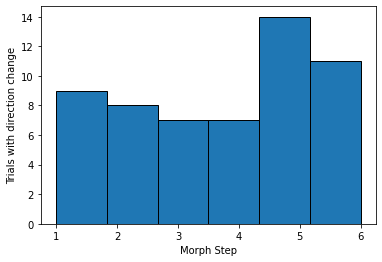

In [190]:
#-0.8888888888888888, 0.887962962962963
data = get_mouse_range(df, 0, [-0.5,0.5])
print(len(data))
plt.hist(data[:,1], bins=6, edgecolor='black')
plt.xlabel('Morph Step')
plt.ylabel('Trials with direction change')

175


Text(0, 0.5, 'Trials with direction change')

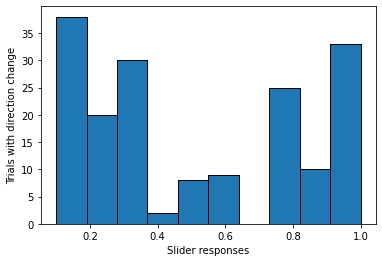

In [188]:
#-0.8888888888888888, 0.887962962962963
data = get_mouse_range(df, 0, [-0.5,0.5])
print(len(data))
plt.hist(data[:,0], edgecolor='black')
plt.xlabel('Slider responses')
plt.ylabel('Trials with direction change')

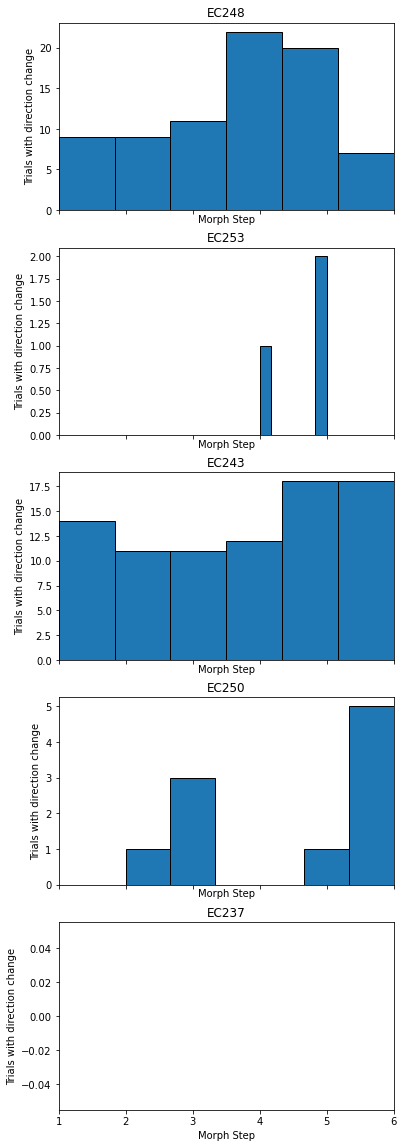

In [187]:
#individual subjects

# plts = PdfPages('individuals_sigmoid_trueline.pdf')
fig, axs = plt.subplots(5, 1, figsize=(6, 20), sharex=True)
axs = axs.flatten()
for i, s in enumerate(subjects):
    df_s = list()
    for j, file in enumerate(files):
        if s in file: df_s.append(dfs[j])
            
    df_s = pd.concat(df_s)
    df_s = df_s.reset_index()
#     print(s)
    data = get_mouse_range(df_s, 0, [-0.5,0.5])
#     print(len(data))
    axs[i].hist(data[:,1], bins=6, edgecolor='black')
    axs[i].set_xlabel('Morph Step')
    axs[i].set_xlim(1,6)
    axs[i].set_ylabel('Trials with direction change')
    axs[i].set_title(s)

#     plts.savefig(plot)
    
# plts.close()     

In [ ]:
#mouse rt - how soon before they move the mouse
#mouse movement time - slider rt (go:slider choice) -mouse rt (go:mouse move)
#mouse distance or turns
#look at the more ambiguous cases
#big question: how ambiguity shows up in behavior- find a behavior that's important to look at neural correlate
#within session or between blocks - learning?
#block number in file name
#4 participants

rt vs slider
rt vs error